## Gestor de películas de IMDB
---

In [1]:
# importando librerías
import datetime
import os
import sys
import re
import time

try:
    import imdb
except ImportError:
    imdb = None

from rdflib import BNode, ConjunctiveGraph, URIRef, Literal, Namespace, RDF
from rdflib.namespace import FOAF, DC

In [97]:
# ubicacion donde estará el archivo RDF
storefn = os.path.expanduser("~/movies.n3")

In [98]:
storeuri = "file://" + storefn
title = "Películas vistas por %s"

# expresion regular para agregar a la persona 
r_who = re.compile(r"^(.*?) <([a-z0-9_-]+(\.[a-z0-9_-]+)*@[a-z0-9_-]+(\.[a-z0-9_-]+)+)>$")

In [99]:
# namespaces de imdb
IMDB = Namespace("http://www.csd.abdn.ac.uk/~ggrimnes/dev/imdb/IMDB#")
REV = Namespace("http://purl.org/stuff/rev#")

In [100]:
class Store:
    def __init__(self):
        self.graph = ConjunctiveGraph()
        if os.path.exists(storefn):
            self.graph.load(storeuri, format="n3")
        self.graph.bind("dc", DC)
        self.graph.bind("foaf", FOAF)
        self.graph.bind("imdb", IMDB)
        self.graph.bind("rev", "http://purl.org/stuff/rev#")

    def save(self):
        self.graph.serialize(storeuri, format="n3")

    def who(self, who=None):
        if who is not None:
            name, email = (r_who.match(who).group(1), r_who.match(who).group(2))
            self.graph.add((URIRef(storeuri), DC["title"], Literal(title % name)))
            self.graph.add((URIRef(storeuri + "#author"), RDF.type, FOAF["Person"]))
            self.graph.add((URIRef(storeuri + "#author"), FOAF["name"], Literal(name)))
            self.graph.add((URIRef(storeuri + "#author"), FOAF["mbox"], Literal(email)))
            self.save()
        else:
            return self.graph.objects(URIRef(storeuri + "#author"), FOAF["name"])

    def new_movie(self, movie):
        movieuri = URIRef("http://www.imdb.com/title/tt%s/" % movie.movieID)
        self.graph.add((movieuri, RDF.type, IMDB["Movie"]))
        self.graph.add((movieuri, DC["title"], Literal(movie["title"])))
        self.graph.add((movieuri, IMDB["year"], Literal(int(movie["year"]))))
        self.save()

    def new_review(self, movie, date, rating, comment=None):
        review = BNode()  # @@ humanize the identifier (something like #rev-$date)
        movieuri = URIRef("http://www.imdb.com/title/tt%s/" % movie.movieID)
        self.graph.add((movieuri, REV["hasReview"], URIRef("%s#%s" % (storeuri, review))))
        self.graph.add((review, RDF.type, REV["Review"]))
        self.graph.add((review, DC["date"], Literal(date)))
        self.graph.add((review, REV["maxRating"], Literal(5)))
        self.graph.add((review, REV["minRating"], Literal(0)))
        self.graph.add((review, REV["reviewer"], URIRef(storeuri + "#author")))
        self.graph.add((review, REV["rating"], Literal(rating)))
        if comment is not None:
            self.graph.add((review, REV["text"], Literal(comment)))
        self.save()

    def movie_is_in(self, uri):
        return (URIRef(uri), RDF.type, IMDB["Movie"]) in self.graph

    def returnGraph(self):
        return self.graph
    
s = Store()

In [101]:
def add(name):
    if os.path.exists(storefn):
        print(list(s.who())[0])
    else:
        s.who(name)
        
add(r"Jordi Bardales <jbardales@outlook.com>")

Jordi Bardales


In [92]:
def addMovie(url_movie):
    if s.movie_is_in(url_movie):
        print("La pelicula ya fue registrada")
    else:
        i = imdb.IMDb()
        movie = i.get_movie(url_movie[len("https://www.imdb.com/title/tt") : -1])
        print("%s (%s)" % (movie["title"].encode("utf-8"), movie["year"]))
        for director in movie["director"]:
            print("directed by: %s" % director["name"].encode("utf-8"))
        for writer in movie["writer"]:
            print("written by: %s" % writer["name"].encode("utf-8"))
        s.new_movie(movie)
        rating = None
        while not rating or (rating > 5 or rating <= 0):
            try:
                rating = int(eval(input("Rating (on five): ")))
            except ValueError:
                rating = None
        date = None
        while not date:
            try:
                i = eval(input("Review date (YYYY-MM-DD): "))
                date = datetime.datetime(*time.strptime(i, "%Y-%m-%d")[:6])
            except:
                date = None
        comment = eval(input("Comment: "))
        s.new_review(movie, date, rating, comment)
        print("La pelicula registrada correctamente.")

In [93]:
addMovie("https://www.imdb.com/title/tt1277953/")

b"Madagascar 3: Europe's Most Wanted" (2012)
directed by: b'Eric Darnell'
directed by: b'Tom McGrath'
directed by: b'Conrad Vernon'
written by: b'Eric Darnell'
written by: b'Noah Baumbach'
written by: b'Mark Burton'


Rating (on five):  4
Review date (YYYY-MM-DD):  "2020-12-12"
Comment:  "OK"


La pelicula registrada correctamente.


## Visualización del grafo
---

In [102]:
import networkx as nx
import matplotlib.pyplot as plt

class GraphVisualization:
    def __init__(self):
        self.visual = []

    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)
        
    def visualize(self):
        G = nx.DiGraph()
        G.add_edges_from(self.visual)
        # configuracion de los nodos
        # nx.draw_networkx(G, font_family="Arial", font_size=10, node_size=100, node_shape="o", node_color='r', with_labels=True)
        nx.draw_networkx(G)
        plt.show()

http://www.csd.abdn.ac.uk/~ggrimnes/dev/imdb/IMDB#year
http://purl.org/dc/elements/1.1/title
http://www.w3.org/1999/02/22-rdf-syntax-ns#type
http://xmlns.com/foaf/0.1/name
http://purl.org/stuff/rev#rating
http://purl.org/stuff/rev#minRating
http://www.w3.org/1999/02/22-rdf-syntax-ns#type
http://purl.org/dc/elements/1.1/date
http://purl.org/stuff/rev#hasReview
http://purl.org/stuff/rev#maxRating
http://purl.org/stuff/rev#text
http://purl.org/stuff/rev#reviewer
http://www.w3.org/1999/02/22-rdf-syntax-ns#type
http://xmlns.com/foaf/0.1/mbox
http://purl.org/dc/elements/1.1/title


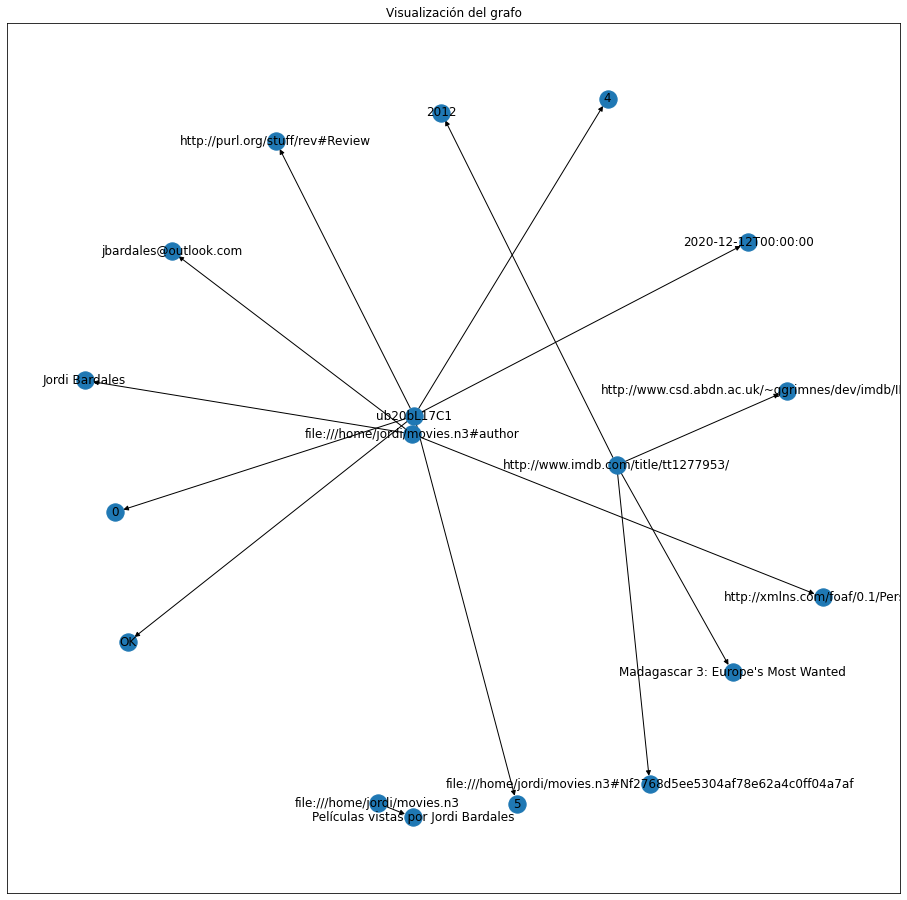

In [107]:
G = GraphVisualization()

for subject,predicate,obj_ in s.returnGraph():
    print(predicate)
    G.addEdge(subject, obj_)
    
plt.figure(figsize=(16, 16))
ax = plt.gca()
ax.set_title('Visualización del grafo')

G.visualize()